# How to Use TrendCluster

## Intro

Start with necessary packages and functions.

In [2]:
import pandas as pd
import numpy as np
from trendy import * # important things are here
import time
from matplotlib import pyplot
import datetime
from helper import _get_cookie_crumb
import plotly as py
import plotly.graph_objs as go
from IPython.display import Image
py.offline.init_notebook_mode(connected=True)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
_crumb = _get_cookie_crumb() # for auth

In [4]:
def date_to_unix(d):
    return int(time.mktime(datetime.datetime.strptime(d, "%d/%m/%Y").timetuple()))

I think stocks trends are good examples for this purpose since it's easy for human eyes to cluster them. Here, I download price changes over the time for Apple (AAPL), Twitter (TWTR), Microsoft (MSFT) and Facebook (FB). I use `Open` prices for training set and `Close` prices for test set.

In [5]:
start = date_to_unix("01/04/2017")
end = int(time.time())
ticker = ['AAPL', 'TWTR', 'MSFT', 'FB']
def get_data(ticker=ticker, start=start, end=end, remove=['Adj Close', 'Volume', 'Close', 'High', 'Low']):
    dfs = []
    for i in range(len(ticker)):
        url = 'https://query1.finance.yahoo.com/v7/finance/download/{}?period1={}&period2={}&interval=1d&events=history&crumb={}'.format(ticker[i], start, end, _crumb)
        tmp_df = pd.read_csv(url)
        tmp_df = tmp_df.drop(remove, axis=1)
        tmp_df.columns = ['Date'] + [c+'_'+ticker[i] for c in tmp_df.columns if not c.startswith('Dat')]
        if not i:
            df = tmp_df
        else:
            df = df.merge(tmp_df, how='inner', on='Date', suffixes=('_x', '_ticker[i]'))
    
    df.index = df.Date
    df = df.drop(['Date'], axis=1)
    return df
    
train = get_data()
test = get_data(remove=['Adj Close', 'Volume', 'High', 'Low', 'Open'])

## Training

`AAPL` and `FB` are in the upper of the graph with prices around 150-200. `MSFT` is around 60-100. And, `TWTR` is around 20-30.

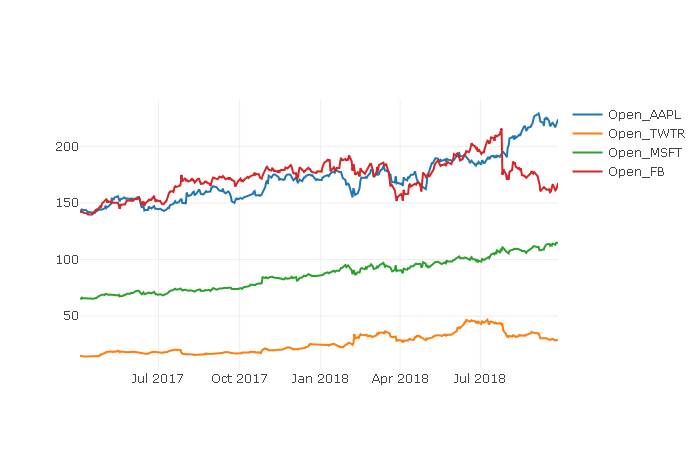

In [6]:
def to_plot(df):
    out = []
    for c in df.columns:
        tmp = go.Scatter(x=df.index, y=df[c], mode = 'lines', name=c)
        out.append(tmp)
    return out

py.offline.plot(to_plot(train), filename = 'asset/train.html', auto_open=False)
Image('asset/train.png')

It's obvious that we would put `AAPL` and `FB` in one and `MSFT` and `TWTR` in another if we need to create two clusters these four stocks. Let's see how `TrendCluster` works.

In [7]:
clusterer = TrendCluster()
clusterer.fit(train.to_dict('list'), n=2, scale=False)
print clusterer.clusters

{'Open_AAPL': ['Open_AAPL', 'Open_FB'], 'Open_MSFT': ['Open_MSFT', 'Open_TWTR']}


Things go as expected. I use dictionary keys as cluster names to utilize them during assignment of new series.

## Test

Now, let's assign new series to clusters created.

In [8]:
test.head()

,Close_AAPL,Close_TWTR,Close_MSFT,Close_FB
Date,,,,
2017-04-03,143.699997,14.84,65.550003,142.279999
2017-04-04,144.770004,14.69,65.730003,141.729996
2017-04-05,144.020004,14.53,65.559998,141.850006
2017-04-06,143.660004,14.39,65.730003,141.169998
2017-04-07,143.339996,14.29,65.680000,140.779999


In [9]:
for c in test.columns:
    clusterer.assign({c:test[c]}, save=True)

In [10]:
clusterer.clusters

{'Open_AAPL': ['Open_AAPL', 'Open_FB', 'Close_AAPL', 'Close_FB'],
 'Open_MSFT': ['Open_MSFT', 'Open_TWTR', 'Close_TWTR', 'Close_MSFT']}

## Scaling

If we really need to cluster trends, not the actual series, then we need to scale them first. `scale` argument can be used for this purpose.

In [11]:
clusterer_scaled = TrendCluster()
clusterer_scaled.fit(train.to_dict('list'), n=2, scale=True)
print clusterer_scaled.clusters

{'Open_AAPL': ['Open_AAPL', 'Open_MSFT'], 'Open_TWTR': ['Open_TWTR', 'Open_FB']}


Clusters are constructed differently this time. Let's look at the training data again after scaling the values.

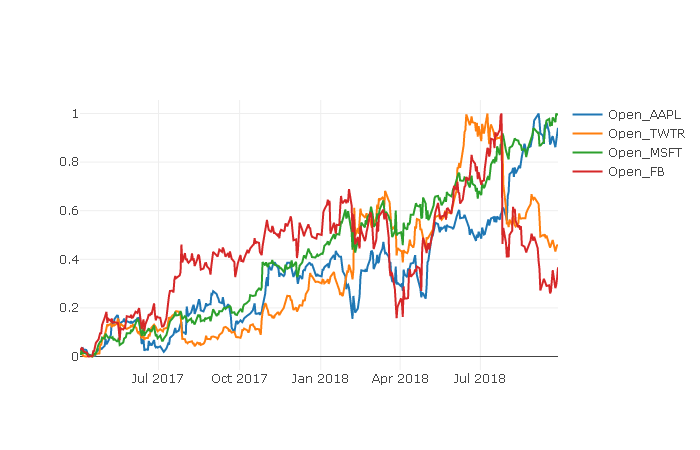

In [12]:
py.offline.plot(to_plot(train.apply(lambda x: array_scaler(x))), filename = 'asset/train_scaled.html', auto_open=False)
Image('asset/train_scaled.png')

Huge drops can be seen around March and July 2018 on `FB` and `TWTR`. `AAPL` and `MSFT` increase less volatilely comparing to others. This explains the different cluster structure here.

## Endnote

I believe this is a good starting point for this project and might be helpful for many individual. There are still things to be improved though. A few of them are;
- Missing values need to be handled before using `TrendCluster`.
- `fit` method is still very slow.
- Extra methods such as manual cluster updates or visualization might be beneficial for other use cases.
- Make `stationary` option can be added.